# Number of layer clusters per 3D cluster

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist
import hist.plot

sys.path.append("../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v32'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data"}

In [24]:
h= (histStore
    .get(HistogramId("Clus3DSize", clueParams, "data"))
    .getHistogram(HistogramKind.COUNT)[{
        "beamEnergy" : hist.loc(20),
        "mainOrAllTracksters" : hist.loc("mainTrackster"),
    }]
)
h

Hist(Integer(1, 50, name='clus3D_size_custom', label='3D cluster size ie number of 2D clusters that make out this 3D cluster'), storage=Double()) # Sum: 19798.0

In [39]:
def countHistogramToWeightHistogram(h:hist.Hist):
    """ Transform a count boost.histogram (ie Double storage type) to a Weight storage histogram, with weights=1 """
    w_h = hist.Hist(*h.axes, storage=hist.storage.Weight())
    w_h.view(flow=True).value, w_h.view(flow=True).variance = h.view(flow=True), h.view(flow=True)
    return w_h

In [40]:
countHistogramToWeightHistogram(h)

Hist(Integer(1, 50, name='clus3D_size_custom', label='3D cluster size ie number of 2D clusters that make out this 3D cluster'), storage=Weight()) # Sum: WeightedSum(value=19798, variance=19798)

## Data / simulation comparison
Simulation is normalized to data

In [69]:
def plotDataSim(beamEnergy:int, datatypes:list[str], mainOrAllTracksters:str="mainTrackster"):
    hists = [histStore
    .get(HistogramId("Clus3DSize", clueParams, datatype))
    .getHistogram(HistogramKind.COUNT)[{
        "beamEnergy" : hist.loc(beamEnergy),
        "mainOrAllTracksters" : hist.loc(mainOrAllTracksters),
    }]
    for datatype in datatypes]

    for i in range(len(datatypes)):
        if i == 0:
            count_data = hists[0].sum(flow=True)
        else:
            hists[i] = countHistogramToWeightHistogram(hists[i]) * (count_data / hists[i].sum(flow=True))
    
    plt.figure()
    
    hep.histplot(hists, label=datatypes)
    
    #plt.gca().xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.AutoLocator())
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xlabel("Number of layer clusters per 3D cluster")

    if "data" in datatypes:
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext(f"$e^+$ {str(beamEnergy)} GeV")
    plt.legend()

    

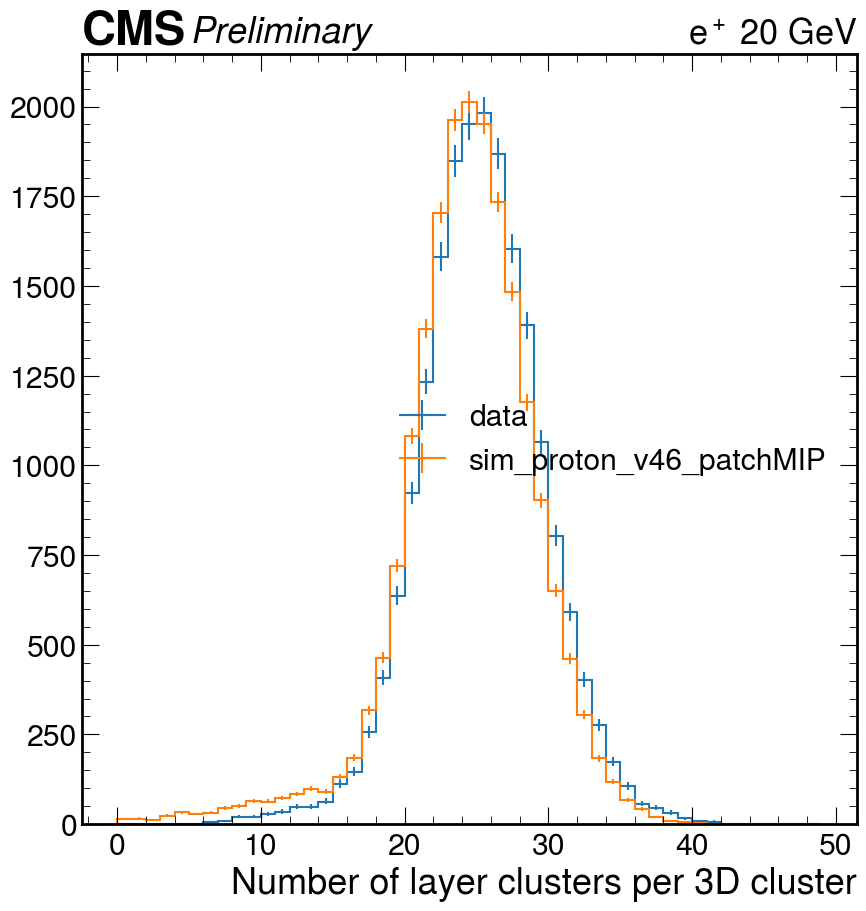

In [50]:
plotDataSim(20, ["data", "sim_proton_v46_patchMIP"])

### As ratio plot

In [72]:

def plotDataSimRatio(beamEnergy:int, datatypes:list[str], mainOrAllTracksters:str="mainTrackster"):
    hists = [histStore
    .get(HistogramId("Clus3DSize", clueParams, datatype))
    .getHistogram(HistogramKind.COUNT)[{
        "beamEnergy" : hist.loc(beamEnergy),
        "mainOrAllTracksters" : hist.loc(mainOrAllTracksters),
    }]
    for datatype in datatypes]

    for i in range(len(datatypes)):
        if i == 0:
            count_data = hists[0].sum(flow=True)
        else:
            hists[i] = countHistogramToWeightHistogram(hists[i]) * (count_data / hists[i].sum(flow=True))
    
    fig = plt.figure()
    grid = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])

    main_ax:plt.Axes = fig.add_subplot(grid[0])
    subplot_ax:plt.Axes = fig.add_subplot(grid[1], sharex=main_ax)
    
    hep.histplot(hists, label=datatypes, ax=main_ax)

    with np.errstate(divide="ignore", invalid="ignore"):
        ratios = hists[0].values() / hists[1].values()
        ratio_uncert = hist.intervals.ratio_uncertainty(
            num=hists[0].values(),
            denom=hists[1].values(),
            uncertainty_type="poisson", # Assume numerator is Poisson (ignore uncertainty on MC)
        )
        hist.plot.plot_ratio_array(hists[0], ratios, ratio_uncert, subplot_ax, ylim=(0.2,2), ylabel="Ratio")
    
    #plt.gca().xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    main_ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())
    main_ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    main_ax.set_ylabel("Event count")
    main_ax.set_xlabel("")
    subplot_ax.set_xlabel("Number of layer clusters per 3D cluster")

    if "data" in datatypes:
        hep.cms.text("Preliminary", ax=main_ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=main_ax)
    hep.cms.lumitext(f"$e^+$ {str(beamEnergy)} GeV", ax=main_ax)
    main_ax.legend()

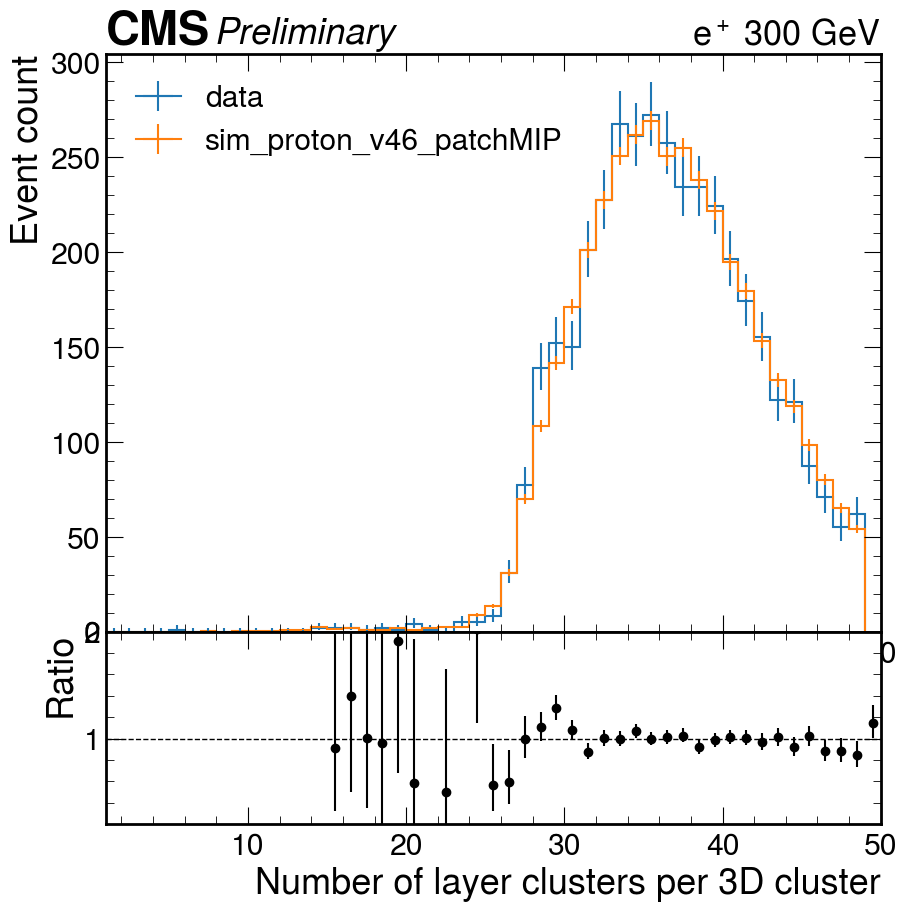

In [74]:
plotDataSimRatio(300, ["data", "sim_proton_v46_patchMIP"])